In [1]:
import matplotlib.pyplot as plt
import matplotlib.dates as dates
import matplotlib as mpl
import numpy as np
import pandas as pd
import datetime

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
%matplotlib inline

In [4]:
#พ.ศ. to ค.ศ.
def be_to_ce(date):
    date = date.split("/")
    year = int(date[2]) - 543
    return date[1] + "/" + date[0] + "/" + str(year)

In [5]:
def convert_to_train_set(df):
    df.rename(columns = {"ระดับน้ำ":"water","เวลา":"time","วันที่":"date"}, inplace=True)

    #drop nan
    df.dropna(subset=["water","time","date"],how='any',inplace=True)

    #adjust to base on mean sea level
    df["water"] -= 2.5

    #remove out of bounded value
    df = df.loc[(df["water"] >= -11.65) & (df["water"] <= 11.65)]

    #เปลี่ยน วันที่ ไทย to วันที่ คศ
    df["date_new"] = df.apply(lambda x: be_to_ce(x["date"]), axis = 1)
    df.drop(["date"], axis = 1, inplace=True)
    df.rename(columns = {"date_new":"date"}, inplace=True)

    #create column from merging column date and time
    df["date_time"] = df[['date', 'time']].agg(' '.join, axis=1)
    df["date_time"] = pd.to_datetime(df["date_time"], format="%m/%d/%Y %H:%M:%S")
    df.sort_values("date_time", inplace=True)
    df.reset_index(drop=True,inplace=True)

    #drop duplicate row by keeping first duplicate based on column "date_time"
    df.drop_duplicates(subset=['date_time'], keep='first', inplace=True)

    return df

In [6]:
def filter_time(df,a,b):
    start = pd.to_datetime(a, format="%m/%d/%Y %H:%M:%S")
    end = pd.to_datetime(b, format="%m/%d/%Y %H:%M:%S")
    filter = (df["date_time"] >= start) & (df["date_time"] <= end)
    df_filter = df.loc[filter]

    return df_filter

In [7]:
df_2019 = pd.read_csv('2019.csv')
# df_2019

In [8]:
df_2019 = convert_to_train_set(df_2019)
# df_2019

In [9]:
df_2019 = filter_time(df_2019,"12/1/2019 00:00:00","12/31/2020 23:59:00")
# df_2019

In [10]:
df_2020 = pd.read_csv("2020.csv")
df_2020 = convert_to_train_set(df_2020)
# df_2020

In [11]:
df_2020 = filter_time(df_2020,"1/1/2020 00:00:00","11/30/2020 23:59:59")
# df_2020

In [12]:
df = pd.concat([df_2019,df_2020])
# df

In [13]:
df.sort_values("date_time",inplace=True)
# df

In [14]:
df.to_csv("water.csv")

In [15]:
#clone df and drop
df_train = df.drop(["date","time"], axis=1)
df_train.reset_index(drop=True,inplace=True)
# df_train

,water,date_time
0,-0.72,2019-12-01 00:09:00
1,-0.77,2019-12-01 00:19:00
2,-0.82,2019-12-01 00:29:00
3,-0.86,2019-12-01 00:39:00
4,-0.90,2019-12-01 00:48:00
...,...,...
52143,0.55,2020-11-30 18:24:00
52144,0.49,2020-11-30 18:34:00
52145,0.43,2020-11-30 18:44:00
52146,0.37,2020-11-30 18:54:00


In [16]:
# df_train = df_train.resample("10T", on="date_time").mean().interpolate(method="time")
my_order = 3
my_s = 10
df_train = df_train.resample("10T",on="date_time").mean().interpolate(method="spline",order=my_order,s=my_s)
df_train.reset_index(inplace=True)
# df_train

,date_time,water
0,2019-12-01 00:00:00,-0.72
1,2019-12-01 00:10:00,-0.77
2,2019-12-01 00:20:00,-0.82
3,2019-12-01 00:30:00,-0.86
4,2019-12-01 00:40:00,-0.90
...,...,...
52670,2020-11-30 18:20:00,0.55
52671,2020-11-30 18:30:00,0.49
52672,2020-11-30 18:40:00,0.43
52673,2020-11-30 18:50:00,0.37


In [17]:
df_train = df_train.loc[(df_train["water"] >= -11.65) & (df_train["water"] <= 11.65)]

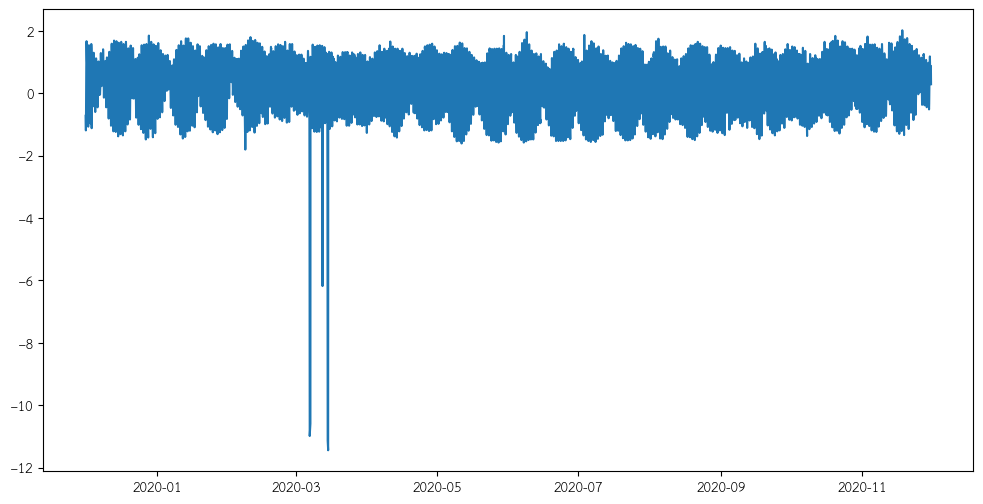

In [18]:
plt.rcParams['font.family'] = ['TH Sarabun New']
plt.rcParams.update({'font.size': 14})
plt.rc('figure',figsize=(12,6))
plt.rc('font',size=15)

x = df_train["date_time"]
y = df_train["water"]
plt.plot(x,y)
plt.show()

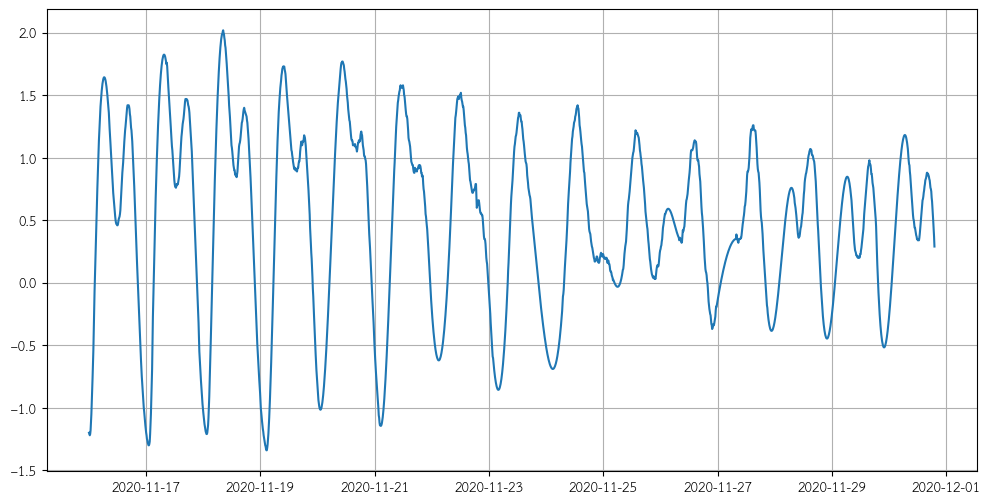

In [19]:
start = pd.to_datetime("11/16/2020 00:00:00", format="%m/%d/%Y %H:%M:%S")
end = pd.to_datetime("11/30/2020 23:50:00", format="%m/%d/%Y %H:%M:%S")
filter = (df_train["date_time"] >= start) & (df_train["date_time"] <= end)
df_filter = df_train.loc[filter]

# df_filter.reset_index(drop=True,inplace=True)
plt.plot(df_filter["date_time"],df_filter["water"])
plt.grid(True)
# plt.title('Order = '+str(my_order)+" s = "+str(my_s))

In [20]:
import statsmodels.api as sm
from statsmodels.tsa.seasonal import STL

In [21]:
stl = STL(df_train['water'].to_numpy(), period = 144)
result = stl.fit()

In [22]:
seasonal, trend, resid = result.seasonal, result.trend, result.resid

cleaned_data = seasonal + trend

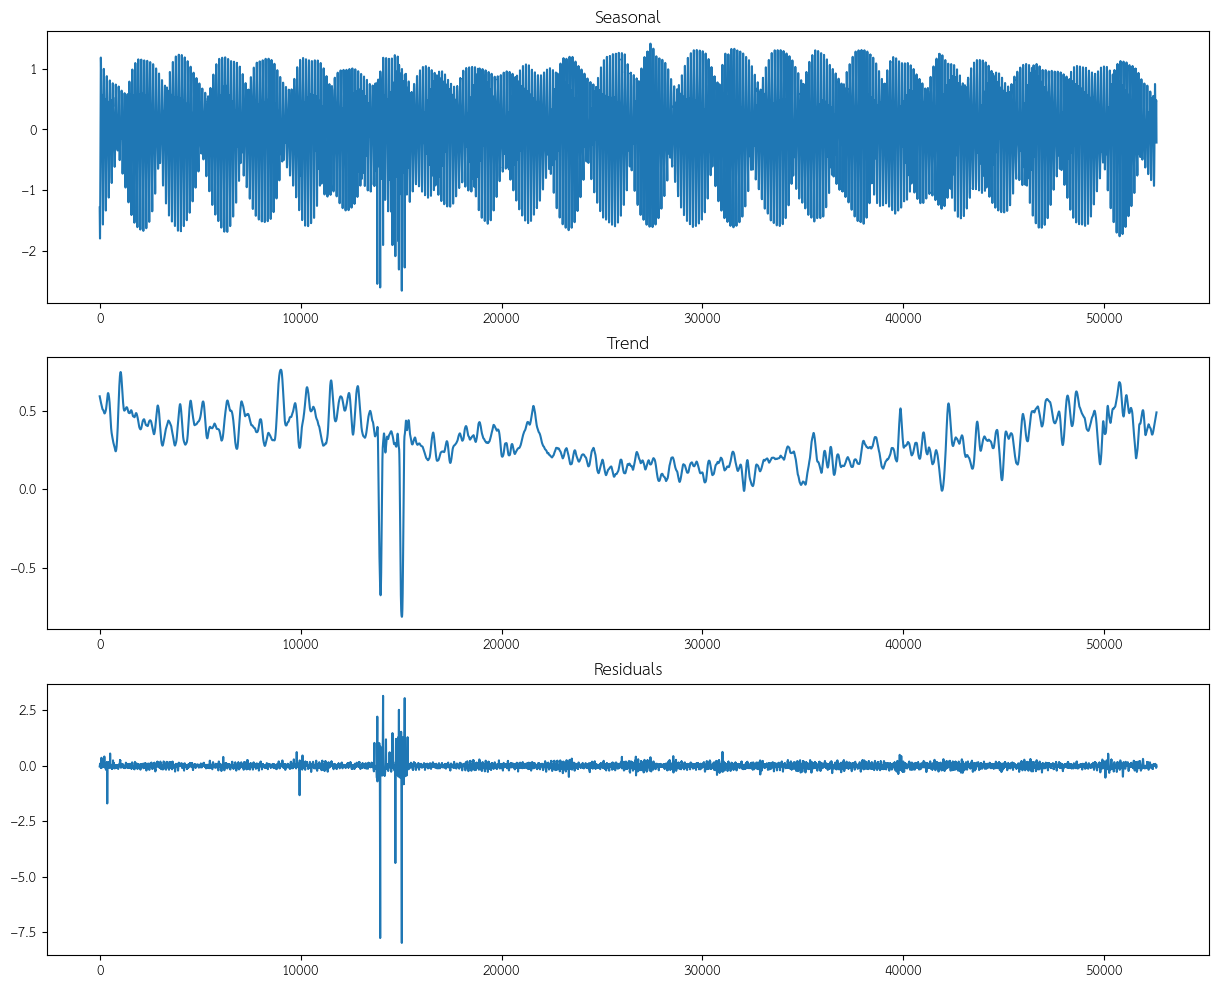

In [23]:
plt.figure(figsize = (15, 12))

plt.subplot(3,1,1)
plt.plot(seasonal)
plt.title('Seasonal')

plt.subplot(3,1,2)
plt.plot(trend)
plt.title('Trend')

plt.subplot(3,1,3)
plt.plot(resid)
plt.title('Residuals')

plt.show()

In [24]:
# res_mean = resid.mean()
# resid_std = resid.std()

# std_factor = .4

# lower_bound = res_mean - std_factor*resid_std
# upper_bound = res_mean + std_factor*resid_std

q3 = np.quantile(resid,.75)
q2 = np.quantile(resid,.5)
q1 = np.quantile(resid,.25)

iqr = q3-q1
iqr_factor = 1.5

lower_bound = q1 - iqr_factor*iqr
upper_bound = q3 + iqr_factor*iqr

print("Lower =",lower_bound)
print("Med =",q2)
print("Upper =",upper_bound)

Lower = -0.2277164023833177
Med = -0.0021032247458973585
Upper = 0.22640428071044927


In [25]:
anomalies = df_train[(resid < lower_bound) | (resid > upper_bound)]
anomalies

,date_time,water
88,2019-12-01 14:40:00,0.950000
232,2019-12-02 14:40:00,0.890000
376,2019-12-03 14:40:00,-1.120000
378,2019-12-03 15:00:00,0.210000
520,2019-12-04 14:40:00,1.030000
...,...,...
52008,2020-11-26 04:00:00,0.577131
52009,2020-11-26 04:10:00,0.570755
52010,2020-11-26 04:20:00,0.563456
52011,2020-11-26 04:30:00,0.555322


In [26]:
i1 = df_train.index
i2 = pd.DataFrame(anomalies).index
df_ets = df_train[~i1.isin(i2)]

# df_ets.reset_index(drop=True,inplace=True)

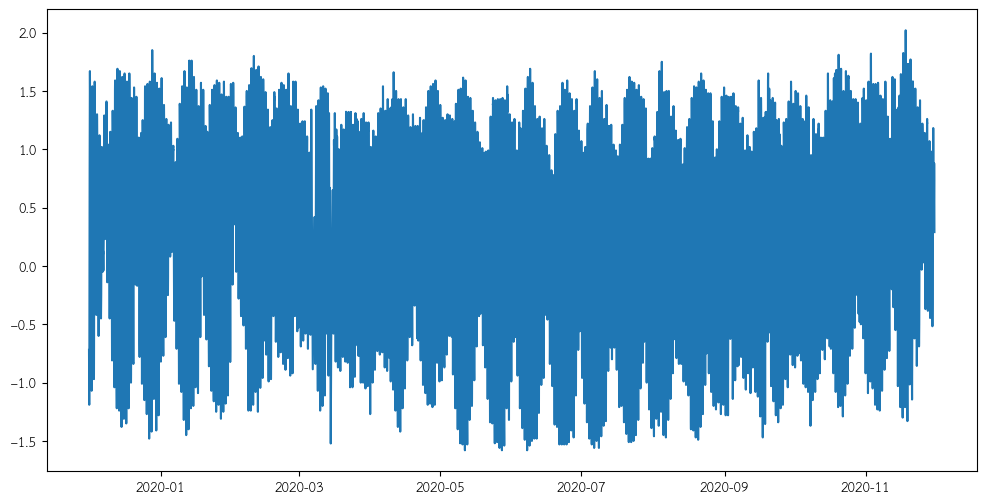

In [27]:
plt.plot(df_ets["date_time"],df_ets["water"])

In [28]:
from statsmodels.tsa.stattools import adfuller

def adf_test(df):
  dftest = adfuller(df, autolag = 'AIC')
  print("1. ADF : ",dftest[0])
  print("2. P-Value : ", dftest[1])
  print("3. Num Of Lags : ", dftest[2])
  print("4. Num Of Observations Used For ADF Regression and Critical Values Calculation :", dftest[3])
  print("5. Critical Values :")
  for key, val in dftest[4].items():
      print("\t",key, ": ", val)

In [29]:
adf_test(df_ets["water"])

1. ADF :  -40.56773308286356
2. P-Value :  0.0
3. Num Of Lags :  57
4. Num Of Observations Used For ADF Regression and Critical Values Calculation : 50748
5. Critical Values :
	 1% :  -3.430478864798662
	 5% :  -2.861596955612978
	 10% :  -2.566800315585874


In [30]:
from statsmodels.tsa.exponential_smoothing.ets import ETSModel

In [31]:
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [32]:
model = ETSModel(df_ets["water"], trend="add",seasonal="add",error="add",
damped_trend=False, seasonal_periods=12)

c:\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [33]:
ets_fitted = model.fit(smoothing_level=.95)

In [34]:
print(ets_fitted.summary())

                                 ETS Results                                  
Dep. Variable:                  water   No. Observations:                50806
Model:                       ETS(AAA)   Log Likelihood               88011.621
Date:                Thu, 17 Nov 2022   AIC                        -175987.242
Time:                        15:25:34   BIC                        -175828.198
Sample:                             0   HQIC                       -175937.459
                              - 50806   Scale                            0.002
Covariance Type:               approx                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
smoothing_level         0.9999      0.004    223.083      0.000       0.991       1.009
smoothing_trend         0.3306      0.003     97.890      0.000       0.324       0.337
smoothing_season

In [35]:
y_pred = ets_fitted.predict(20)

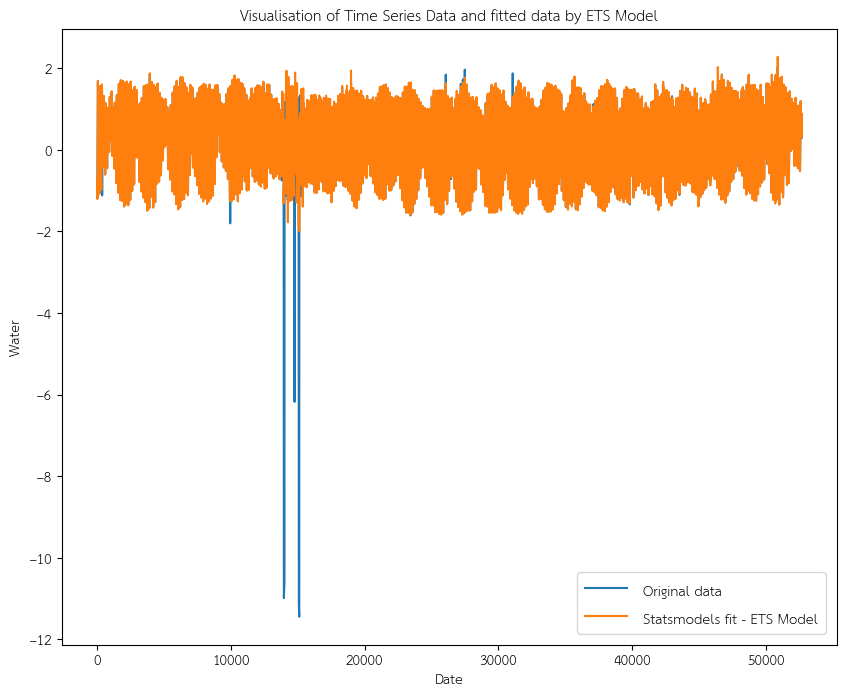

In [36]:
plt.figure(figsize=(10,8))
df_train["water"].plot(label='Original data')
ets_fitted.fittedvalues.plot(label='Statsmodels fit - ETS Model')
plt.title('Visualisation of Time Series Data and fitted data by ETS Model' , fontsize=16)
plt.ylabel("Water")
plt.xlabel("Date")

start = pd.to_datetime("3/1/2020 00:00:00", format="%m/%d/%Y %H:%M:%S")
end = pd.to_datetime("3/31/2020 23:50:00", format="%m/%d/%Y %H:%M:%S")
id_start = df_train.index[df_train["date_time"] == start].tolist()[0]
id_end = df_train.index[df_train["date_time"] == end].tolist()[0]

# plt.xlim([id_start,id_end])
plt.legend()

In [37]:
expected_ets = df_ets["water"]
pred_ets= ets_fitted.fittedvalues
predicted_ets = pred_ets.values

In [38]:
from sklearn.metrics import mean_squared_error

def mean_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean((y_true - y_pred) / y_true * 100)

rmse_ets  = mean_squared_error(expected_ets, predicted_ets, squared=False)

print('In-Sample Error Measures of ETS Models:')
print('')
print('- RMSE: %.2f' % rmse_ets)
# print('- MASE: %.2f' % mase_ets)

In-Sample Error Measures of ETS Models:

- RMSE: 0.04


In [39]:
from pmdarima.arima import auto_arima

In [42]:
df_arima = df_ets.drop(df_ets[df_ets['date_time'].dt.minute != 0].index)
df_arima

,date_time,water
0,2019-12-01 00:00:00,-0.72
6,2019-12-01 01:00:00,-0.97
12,2019-12-01 02:00:00,-1.14
18,2019-12-01 03:00:00,-1.17
24,2019-12-01 04:00:00,-0.74
...,...,...
52650,2020-11-30 15:00:00,0.79
52656,2020-11-30 16:00:00,0.88
52662,2020-11-30 17:00:00,0.82
52668,2020-11-30 18:00:00,0.65


In [ ]:
auto_ar = auto_arima(df_arima["water"], 
                      test='adf',
                      seasonal=True,
                      m=24,
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True,
                      max_d = None,
                      max_D = None,
                       
                      stepwise=True)

In [ ]:
datetime = pd.DataFrame(pd.date_range(start="01/01/2020 00:00",end="12/31/2020 23:50",freq="10min").rename("date_time"))
# datetime.rename(columns={"0":"date_time"},inplace=True)
datetime

,date_time
0,2020-01-01 00:00:00
1,2020-01-01 00:10:00
2,2020-01-01 00:20:00
3,2020-01-01 00:30:00
4,2020-01-01 00:40:00
...,...
52699,2020-12-31 23:10:00
52700,2020-12-31 23:20:00
52701,2020-12-31 23:30:00
52702,2020-12-31 23:40:00


In [ ]:
# df_stamp = pd.merge(datetime, df_train, how="outer", on=["date_time"])
# df_stamp.sort_values("date_time",inplace=True)
# df_stamp.reset_index(drop=True,inplace=True)
# df_stamp

,date_time,water
0,2020-01-01 00:00:00,NaN
1,2020-01-01 00:04:00,-0.28
2,2020-01-01 00:10:00,NaN
3,2020-01-01 00:13:00,-0.33
4,2020-01-01 00:20:00,NaN
...,...,...
97213,2020-12-31 23:10:00,NaN
97214,2020-12-31 23:20:00,NaN
97215,2020-12-31 23:30:00,NaN
97216,2020-12-31 23:40:00,NaN


In [ ]:
# df_stamp.info()
# df_stamp

In [ ]:
# df_stamp["old_data"] = df_stamp.apply(lambda x: False if np.isnan(x["water"]) else True,axis=1)
# df_stamp

In [ ]:
# df_stamp.drop(df_stamp[df_stamp['date_time'].dt.minute % 10 != 0].index, inplace=True)
# df_stamp